In [63]:
#import the packages needed for this question
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [64]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,'html.parser')
my_table = soup.find('tbody')


In [65]:
#collecting all the data in the form of table
table_data = []

for row in my_table.findAll('tr'):
    row_data = []
    
    for cell in row.findAll('td'):
        row_data.append(cell.text)
    
    if(len(row_data) > 0):
        data_item = {
            "Postalcode": row_data[0],
            "Borough": row_data[1],
            "Neighbourhood": row_data[2],
        }
    table_data.append(data_item)

In [66]:
# converting table_data into pandas dataframe
df = pd.DataFrame(table_data)
df.head()

,Postalcode,Borough,Neighbourhood
0,M9Z\n,Not assigned\n,\n
1,M1A\n,Not assigned\n,\n
2,M2A\n,Not assigned\n,\n
3,M3A\n,North York\n,Parkwoods\n
4,M4A\n,North York\n,Victoria Village\n


In [67]:
type(df)

pandas.core.frame.DataFrame

In [68]:
df['Neighbourhood'] = df['Neighbourhood'].str.replace('\n','')
df['Neighbourhood'] = df['Neighbourhood'].str.replace('/',',')
df['Borough'] = df['Borough'].str.replace('\n','')
df['Postalcode'] = df['Postalcode'].str.replace('\n','')

In [69]:
# removing the cells where Borough is Not assigned
df_filtered = df.loc[df['Borough'] != 'Not assigned']
df_filtered.head()

,Postalcode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park , Harbourfront"
6,M6A,North York,"Lawrence Manor , Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [70]:
df_toronto = df_filtered.groupby(['Postalcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
df_toronto

,Postalcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov..."
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam..."


In [71]:
df_toronto.shape

(103, 3)

In [72]:
print('The number of rows in my dataframe = ',df_toronto.shape[0])

The number of rows in my dataframe =  103


##### This is end of answer for Question 1

## Question 2


##### For me, when I tried to import geocoder python package, I got "ModuleNotFoundError" Hence, I used geographical coordinates of the neighborhoods using csv file from the server

In [73]:
df_locations = pd.read_csv('https://cocl.us/Geospatial_data')
df_locations.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Combining df_torornto and df_locations dataframes into a new dataframe

In [74]:
df_toronto_loc = pd.merge(left=df_toronto ,right=df_locations, left_on='Postalcode', right_on='Postal Code', how='inner')
df_toronto_loc.head()

,Postalcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [75]:
df_toronto_loc.drop(['Postal Code'],axis=1,inplace=True)

In [76]:
df_toronto_loc

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam...",43.739416,-79.588437


In [77]:
df_toronto_loc.shape

(103, 5)

In [78]:
print('The final dataframe now has %d rows and %d columns' %(df_toronto_loc.shape[0], df_toronto_loc.shape[1]))

The final dataframe now has 103 rows and 5 columns


#### This is the end of solution for Question 2

### Question 3

#### Explore and cluster the neighborhoods in Toronto

#### Using geopy library to get the latitude and longitude values of Toronto City. Using Nominatim to convert an address into latitude and longitude values

In [79]:
from geopy.geocoders import Nominatim

##### Selecting the Boroughs whos name has Toronto word in it

In [80]:
df_toronto = df_toronto[df_toronto['Borough'].str.contains('Toronto')].reset_index(drop=True)
print(df_toronto.shape)
df_toronto.head()

(39, 3)


,Postalcode,Borough,Neighbourhood
0,M4E,East Toronto,The Beaches
1,M4K,East Toronto,"The Danforth West , Riverdale"
2,M4L,East Toronto,"India Bazaar , The Beaches West"
3,M4M,East Toronto,Studio District
4,M4N,Central Toronto,Lawrence Park


In [81]:
import numpy as np
uniqueBoroughs=np.unique(df_toronto['Borough'])

In [82]:
print("So there are total %d Boroughs, which contain Toronto in their name" %(df_toronto['Borough'].nunique()))

So there are total 4 Boroughs, which contain Toronto in their name


In [83]:
uniqueBoroughs

array(['Central Toronto', 'Downtown Toronto', 'East Toronto',
       'West Toronto'], dtype=object)

In [84]:
df_toronto.tail()

,Postalcode,Borough,Neighbourhood
34,M6P,West Toronto,"High Park , The Junction South"
35,M6R,West Toronto,"Parkdale , Roncesvalles"
36,M6S,West Toronto,"Runnymede , Swansea"
37,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"
38,M7Y,East Toronto,Business reply mail Processing CentrE


In [85]:
address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [86]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [87]:
df_toronto_merge = df_toronto_loc[['Postalcode','Borough','Neighbourhood','Latitude','Longitude']]
df_toronto_merge.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [88]:
map_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# Adding markers on the map
for lat, lng, borough, neighborhood in zip(df_toronto_merge['Latitude'], df_toronto_merge['Longitude'], df_toronto_merge['Borough'], df_toronto_merge['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)

map_city


##### Again working with only those Boroughs which contain word 'Toronto' in their name

In [121]:
df_toronto_data = df_toronto_merge[df_toronto_merge['Borough'].str.contains('Toronto')]
df_toronto_data

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park , Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Summerhill West , Rathnelly , South Hill , For...",43.686412,-79.400049


##### Using the Foursquare API to explore the neighborhoods


In [122]:
CLIENT_ID = 'NTSGY4XP4JLKZMSUXJ0DXIGJ4Z2HRF44ZEX3Z2MFCJA2LRS0' # your Foursquare ID
CLIENT_SECRET = '1QJOXGQE01GBPX2X1QZUFBJ1FXZ5LMOCELVFAAZDEOAZMBP0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NTSGY4XP4JLKZMSUXJ0DXIGJ4Z2HRF44ZEX3Z2MFCJA2LRS0
CLIENT_SECRET:1QJOXGQE01GBPX2X1QZUFBJ1FXZ5LMOCELVFAAZDEOAZMBP0


###### Creating functions to get the category types and the nearby venues which will be used later in this notebook

In [124]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

In [125]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

In [126]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [127]:
# getting venues in the 500 meters radius
toronto_venues = getNearbyVenues(names=df_toronto_data['Neighbourhood'],
                                 latitudes=df_toronto_data['Latitude'],
                                 longitudes=df_toronto_data['Longitude']
                                )
toronto_venues

The Beaches
The Danforth West , Riverdale
India Bazaar , The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park , Summerhill East
Summerhill West , Rathnelly , South Hill , Forest Hill SE , Deer Park
Rosedale
St. James Town , Cabbagetown
Church and Wellesley
Regent Park , Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond , Adelaide , King
Harbourfront East , Union Station , Toronto Islands
Toronto Dominion Centre , Design Exchange
Commerce Court , Victoria Hotel
Roselawn
Forest Hill North & West
The Annex , North Midtown , Yorkville
University of Toronto , Harbord
Kensington Market , Chinatown , Grange Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport
Stn A PO Boxes
First Canadian Place , Underground city
Christie
Dufferin , Dovercourt Village
Little Portugal , Trinity
Brockton , Parkdale Village , Exhibition Place
High Park , 

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop
...,...,...,...,...,...,...,...
1676,Business reply mail Processing CentrE,43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1677,Business reply mail Processing CentrE,43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1678,Business reply mail Processing CentrE,43.662744,-79.321558,The Ten Spot,43.664815,-79.324213,Spa
1679,Business reply mail Processing CentrE,43.662744,-79.321558,Toronto Yoga Mamas,43.664824,-79.324335,Yoga Studio


In [128]:
print("This resulted in total %d venues" %(toronto_venues.shape[0]))

This resulted in total 1681 venues


In [129]:
# having a look at some of the found venues
toronto_venues.head(15)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop
5,"The Danforth West , Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
6,"The Danforth West , Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop
7,"The Danforth West , Riverdale",43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant
8,"The Danforth West , Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
9,"The Danforth West , Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop


In [130]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


#### To analyse each neighbourhood, converting 'Venue Category' from categorical to numerical using One Hot Encoding

In [131]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column to this dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighbourhood']

# moving neighborhood column to make it as first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
toronto_onehot.columns

Index(['Yoga Studio', 'Afghan Restaurant', 'Airport', 'Airport Food Court',
       'Airport Gate', 'Airport Lounge', 'Airport Service', 'Airport Terminal',
       'American Restaurant', 'Antique Shop',
       ...
       'Theme Restaurant', 'Thrift / Vintage Store', 'Toy / Game Store',
       'Trail', 'Train Station', 'Vegetarian / Vegan Restaurant',
       'Video Game Store', 'Vietnamese Restaurant', 'Wine Bar',
       'Women's Store'],
      dtype='object', length=235)

In [133]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.00
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
2,Business reply mail Processing CentrE,0.062500,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
3,"CN Tower , King and Spadina , Railway Lands , ...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,Central Bay Street,0.012987,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.012987,...,0.000000,0.00000,0.000000,0.00000,0.00,0.012987,0.000000,0.000000,0.012987,0.00
5,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
6,Church and Wellesley,0.025316,0.012658,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.012658,...,0.012658,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
7,"Commerce Court , Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.040000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.00
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.027778,...,0.000000,0.00000,0.027778,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00


#### Building the Top 10 venues into a new dataframe

In [134]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [135]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(39, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Seafood Restaurant,Farmers Market,Restaurant,Café,Beer Bar,Department Store
1,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Breakfast Spot,Pet Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
2,Business reply mail Processing CentrE,Yoga Studio,Auto Workshop,Comic Shop,Park,Pizza Place,Burrito Place,Restaurant,Brewery,Light Rail Station,Smoke Shop
3,"CN Tower , King and Spadina , Railway Lands , ...",Airport Terminal,Airport Lounge,Airport Service,Rental Car Location,Boat or Ferry,Coffee Shop,Boutique,Harbor / Marina,Bar,Airport Gate
4,Central Bay Street,Coffee Shop,Italian Restaurant,Thai Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Café,Dessert Shop,Spa,Salad Place


#### Clustering the Neighbourhoods using kmeans clustering

In [136]:
from sklearn.cluster import KMeans

In [137]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

##### Finding the optimal number of clusters for clustering the neighbourhoods

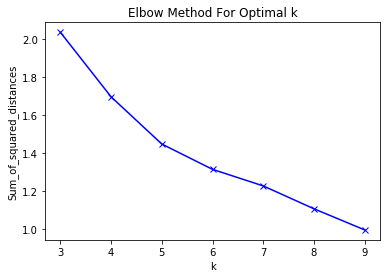

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline
Sum_of_squared_distances = []
K = range(3,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


##### In the above graph the elbow is at k=6, hence clustering the neighborhoods in 6 clusters

In [139]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 2, 0,
       0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

###### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [140]:
toronto_merged = df_toronto_data
# adding clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

print(toronto_merged.shape)
toronto_merged.head()


(39, 16)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Coffee Shop,Trail,Health Food Store,Doner Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
41,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Grocery Store,Pub,Pizza Place,Lounge
42,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572,0,Sandwich Place,Movie Theater,Food & Drink Shop,Restaurant,Burrito Place,Italian Restaurant,Liquor Store,Intersection,Pub,Fast Food Restaurant
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Yoga Studio,Comfort Food Restaurant,Bookstore,Sandwich Place
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Lawyer,Park,Bus Line,Swim School,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [141]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [144]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

##### Finally, checking what is there in each cluster


##### Cluster 1

In [145]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,0,Pub,Coffee Shop,Trail,Health Food Store,Doner Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
41,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Grocery Store,Pub,Pizza Place,Lounge
42,East Toronto,0,Sandwich Place,Movie Theater,Food & Drink Shop,Restaurant,Burrito Place,Italian Restaurant,Liquor Store,Intersection,Pub,Fast Food Restaurant
43,East Toronto,0,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Yoga Studio,Comfort Food Restaurant,Bookstore,Sandwich Place
44,Central Toronto,0,Lawyer,Park,Bus Line,Swim School,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
45,Central Toronto,0,Sandwich Place,Breakfast Spot,Hotel,Food & Drink Shop,Convenience Store,Department Store,Park,Gym,Eastern European Restaurant,Dumpling Restaurant
46,Central Toronto,0,Clothing Store,Coffee Shop,Sporting Goods Shop,Fast Food Restaurant,Diner,Dessert Shop,Mexican Restaurant,Park,Chinese Restaurant,Café
47,Central Toronto,0,Pizza Place,Dessert Shop,Sandwich Place,Sushi Restaurant,Gym,Coffee Shop,Italian Restaurant,Café,Farmers Market,Indoor Play Area
48,Central Toronto,0,Playground,Summer Camp,Women's Store,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
49,Central Toronto,0,Coffee Shop,Pub,Sushi Restaurant,Liquor Store,Supermarket,Bank,Sports Bar,Fried Chicken Joint,Pizza Place,American Restaurant


##### Cluster 2

In [146]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] +list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
67,Downtown Toronto,1,Café,Vietnamese Restaurant,Coffee Shop,Bar,Mexican Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Grocery Store,Park,Burger Joint


##### Cluster 3

In [147]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] +list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,Seafood Restaurant,Gastropub,American Restaurant,Bar,Italian Restaurant,Sporting Goods Shop


##### Cluster 4

In [148]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] +list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Downtown Toronto,3,Airport Terminal,Airport Lounge,Airport Service,Rental Car Location,Boat or Ferry,Coffee Shop,Boutique,Harbor / Marina,Bar,Airport Gate


##### Cluster 5

In [149]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] +list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,Downtown Toronto,4,Restaurant,Coffee Shop,Café,Hotel,Gym,Bar,Bakery,Thai Restaurant,Asian Restaurant,Salad Place


##### Cluster 6

In [150]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] +list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Downtown Toronto,5,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant,Hotel,Men's Store,Mediterranean Restaurant,Yoga Studio,Gastropub


#### From above clustering, the Cluster 1 seems to be more widespread which covers all the boroughs which have word 'Toronto' in their name.


### This is the end of solution for question 3

### This is the End of the Notebook.